In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import PIL

import read_datasets as rd
import constants as CONST
from importlib import reload
reload(rd)
reload(CONST)

import base64
import string
import pickle
import spacy
import collections
import itertools, collections

from scipy.spatial import distance

In [2]:
pd.options.display.max_rows = 500

In [3]:
import finetune
reload(finetune)
from finetune import *

In [4]:
# feature_folder_template = "/raid/xiaoyuz1/sketch_datasets/face_features_weight_5/clip/{}"
# face_feature_dict = rd.get_features(feature_folder_template, list(CONST.face_part_image_indices.keys()))

# feature_folder_template = "/raid/xiaoyuz1/sketch_datasets/angel_features_weight_5/clip/{}"
# angel_feature_dict = rd.get_features(feature_folder_template, list(CONST.angel_part_image_indices.keys()))

In [5]:
# count = 0
# GPUS = ["2","3","5"]
# for f in os.listdir('/raid/xiaoyuz1/clip_model_checkpoint'):
#     if f.endswith(".pt"):
#         full_path = os.path.join('/raid/xiaoyuz1/clip_model_checkpoint' ,f)
#         full_save_path = full_path.replace("pt", "pickle")
#         print("\n")
#         print("python clip_finetune.py --test --GPU {} --test_model_path {} --test_save_path {}".format(
#             GPUS[count % 3], full_path, full_save_path))
#         count += 1

In [21]:
# dfn = new_df_pair()
dfo = pd.read_csv('/raid/xiaoyuz1/amazon_turk/df_all.csv')
dfo['no_punc_1'] = dfo.no_punc_1.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])
# dfn = new_df_pair()
dfp = pd.read_csv('/raid/xiaoyuz1/amazon_turk/df_all_pair.csv')
dfp['no_punc_1'] = dfp.no_punc_1.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])
dfp['no_punc_2'] = dfp.no_punc_2.apply(lambda x: [str(y).strip()[1:-1] for y in x[1:-1].split(',')])

# Load models

In [50]:
import nltk
nltk.download('wordnet')

from nltk.corpus import wordnet
from nltk.corpus import wordnet as wn
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/xiaoyuz1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/xiaoyuz1/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
import clip
import torch

In [5]:
# import open_clip

In [6]:
# nlp = spacy.load("en_core_web_sm")

In [22]:
filename = '/raid/xiaoyuz1/glove300_2word2vec_model.sav'
glovemodel = pickle.load(open(filename, 'rb'))

In [7]:
device = "cuda:6" if torch.cuda.is_available() else "cpu"

In [9]:
args = {}

In [10]:
root_folder = '/raid/xiaoyuz1/clip_model_checkpoint'
torch_path_name = os.path.join(root_folder, "pleasant-tree-10.pt")
checkpoint = torch.load(torch_path_name)
print(checkpoint.keys())
args = checkpoint['args']

dict_keys(['epoch', 'iteration', 'model_state_dict', 'optimizer_state_dict', 'loss', 'args'])


In [11]:

if 'open_clip' in args and args['open_clip']:
    model, train_transform, preprocess = \
        open_clip.create_model_and_transforms('ViT-B-32-quickgelu', \
                                              pretrained='laion400m_e32', device = device)    
else:
    model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training
    

In [12]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [13]:
from transformers import BertTokenizer, BertModel
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model = bert_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
modelzs, _ = clip.load("ViT-B/32",device=device,jit=False) 

In [16]:
root_folder = '/raid/xiaoyuz1/clip_model_checkpoint'
torch_path_name_face = os.path.join(root_folder, "fearless-salad-4.pt")
checkpoint_face = torch.load(torch_path_name_face)

args_face = checkpoint_face['args']

if 'open_clip' in args and args_face['open_clip']:
    model_face, _, preprocess_face = \
        open_clip.create_model_and_transforms('ViT-B-32-quickgelu', \
                                              pretrained='laion400m_e32', device = device)    
else:
    model_face, preprocess_face = clip.load("ViT-B/32", \
                                            device=device,jit=False) 
model_face.load_state_dict(checkpoint_face['model_state_dict'])

<All keys matched successfully>

# Single dfn

### Process

In [ ]:
dfs, selected_pairss, df_inputs, df_idx_to_task_idxs = \
    rd.compile_face_dfs()

In [ ]:
dfo = rd.new_df(dfs, df_idx_to_task_idxs, skip=[0])
dfo.head()

In [ ]:
escape_list = ["shaped", "shape", "and", "like", "sized"]

for i in range(1,2):
    i = str(i)
    dfo['tokenized_{}'.format(i)] = dfo['text_{}'.format(i)].apply(
        lambda x: [y.lemma_ for y in nlp(x) if y.text not in escape_list]
    )
    dfo['lower_{}'.format(i)] = dfo['tokenized_{}'.format(i)].apply(lambda x: [word.lower() for word in x])
    
    punc = string.punctuation
    dfo['no_punc_{}'.format(i)] = dfo['lower_{}'.format(i)].apply(
        lambda x: [word for word in x if word not in punc]
    )
    dfo['no_punc_str_{}'.format(i)] = [' '.join(map(str, l)) for l in dfo['no_punc_{}'.format(i)]]

In [ ]:
dfo.to_csv('/raid/xiaoyuz1/amazon_turk/df_all.csv', index=False) 

### Preliminary analysis

In [ ]:
def print_info(df):
    print("Total number of rows in dataframe:", len(df))
    print("\nNumber of rows for face: ", len(df[df['category'] == 'face']))
    facestr = []
    for k,v in CONST.face_parts_idx_dict.items():
        x = len(df[(df['category'] == 'face') & (df['part'] == k)])
        facestr.append(str(x))
        print("(face) #{} =".format(v), x)
    print(" & ".join(facestr))
    
    print("\nNumber of rows for angel: ", len(df[df['category'] == 'angel']))
    angelstr = []
    for k,v in CONST.angel_parts_idx_dict.items():
        x = len(df[(df['category'] == 'angel') & (df['part'] == k)])
        angelstr.append(str(x))
        print("(angel) #{} =".format(v), x)
    print(" & ".join(angelstr))
    
    print("\nNumber of unique workers:", len(df['worker_id'].unique()))

In [ ]:
print_info(dfo)

In [37]:
def num_unique_words(df):
    corpus = list(df['no_punc_1'].to_numpy())
    corpus = list(itertools.chain.from_iterable(corpus))

    counter = collections.Counter(corpus)
    delete_list = []
    for k,v in counter.items():
        
        if k.strip() == '':
            delete_list += [k]
    for k in delete_list:
        del counter[k]
    return counter

In [49]:



facestr = []
for k,v in CONST.face_part_image_indices.items():
    x = num_unique_words(dfo[(dfo['category'] == 'face') & (dfo['part'] == k)])
    x = len(x)
    facestr.append(str(x))
print(" \t ".join(facestr))

angelstr = []
for k,v in CONST.angel_part_image_indices.items():
    x = num_unique_words(dfo[(dfo['category'] == 'angel') & (dfo['part'] == k)])
    x = len(x)
    angelstr.append(str(x))
print(" \t ".join(angelstr))




227 	 358 	 323 	 152 	 313
363 	 112 	 21 	 87 	 378 	 423 	 532


In [ ]:
sum([int(x) for x in angelstr])

In [20]:
def print_corpus_info(df, cat=None):
    if cat is None:
        dfcat = df
    else:
        dfcat = df[df['category'] == cat]
    corpus = list(dfcat['no_punc_1'].to_numpy())
    corpus = list(itertools.chain.from_iterable(corpus))

    counter = collections.Counter(corpus)
    print("Number of distinct words:", len(counter))
    most = counter.most_common()

    x, y= [], []
    for word,count in most[:100]:
        x.append(word)
        y.append(count)
    plt.figure(figsize=(20,20))
    print("Total count of top frequent words: ", sum(y))
    sns.barplot(x=y,y=x)



Number of distinct words: 1452
Total count of top frequent words:  16047


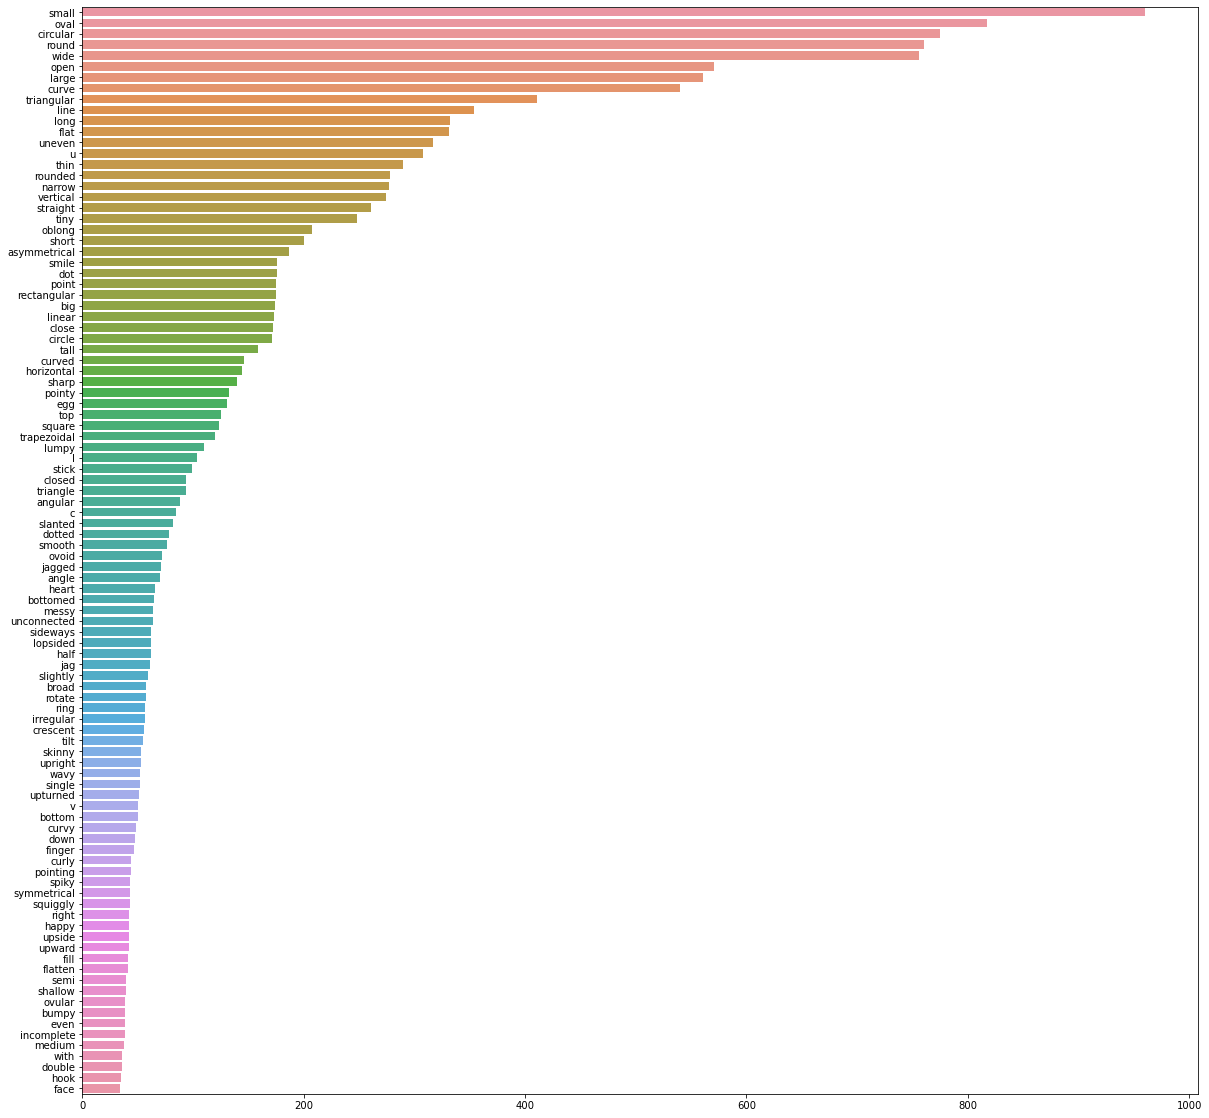

In [21]:
print_corpus_info(dfo)

In [11]:
from wordcloud import WordCloud 
import requests

In [50]:
def word_cloud(df, topn = 100):
    dfcat = df.reset_index(drop=True)
    corpus = list(dfcat['no_punc_1'].to_numpy())
    corpus = list(itertools.chain.from_iterable(corpus))

    counter = collections.Counter(corpus)
    comment_words = " "
    most = counter.most_common()
    x, y= [], []
    for word,count in most[:topn]: 
        comment_words += " ".join([word])+" "

    wordcloud = WordCloud(width = 2000, height = 2000, 
                    background_color ='white',
                    min_font_size = 4).generate(comment_words)
    plt.figure(figsize = (5, 5), facecolor = 'white', edgecolor='blue') 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()
    #return comment_words
    return comment_words

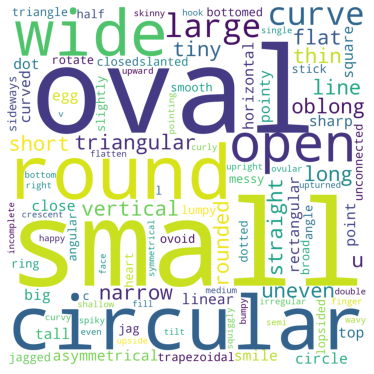

In [51]:
sc = word_cloud(dfo)

In [38]:
counter = num_unique_words(dfo)
most = counter.most_common()

In [46]:
'substantial' in counter

False

In [47]:
row = 14
for i in range(20):
    start = i * row
    end = (i+1) * row
    for j in range(start,end):
        print(most[j][0])
    print("\n")

small
oval
circular
round
wide
open
large
curve
triangular
line
long
flat
uneven
u


thin
rounded
narrow
vertical
straight
tiny
oblong
short
asymmetrical
smile
dot
point
rectangular
big


linear
close
circle
tall
curved
horizontal
sharp
pointy
egg
top
square
trapezoidal
lumpy
l


stick
closed
triangle
angular
c
slanted
dotted
smooth
ovoid
jagged
angle
heart
bottomed
messy


unconnected
sideways
lopsided
half
jag
slightly
broad
rotate
ring
irregular
crescent
tilt
skinny
upright


wavy
single
upturned
v
bottom
curvy
down
finger
curly
pointing
spiky
symmetrical
squiggly
right


happy
upside
upward
fill
flatten
semi
shallow
ovular
bumpy
even
incomplete
medium
with
double


hook
face
thick
edge
butterfly
sided
deep
beaker
arch
moon
crooked
unsymmetrical
boxy
teardrop


d
disk
parabolic
feather
bell
beady
bowl
fat
elongate
j
full
orient
three
bean


a
lobed
left
slim
trapezoid
rectangle
pear
arrow
low
bent
downward
spiral
fluffy
pizza


proportional
hand
backwards
center
scribble
ball
potato

In [13]:
common_words = [x[0] for x in most[:200]]
with torch.no_grad():
    common_words_features = model.encode_text(torch.cat([clip.tokenize(common_words).to(device)]))
print(common_words_features.shape)

torch.Size([200, 512])


In [14]:
from sklearn.manifold import TSNE                   # final reduction

tsne_model2 = TSNE(perplexity=128, n_components=2, init='pca', n_iter=2500, random_state=23)
clip_values = tsne_model2.fit_transform(common_words_features.cpu().numpy())

/home/xiaoyuz1/anaconda3/envs/clipdraw/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/xiaoyuz1/anaconda3/envs/clipdraw/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


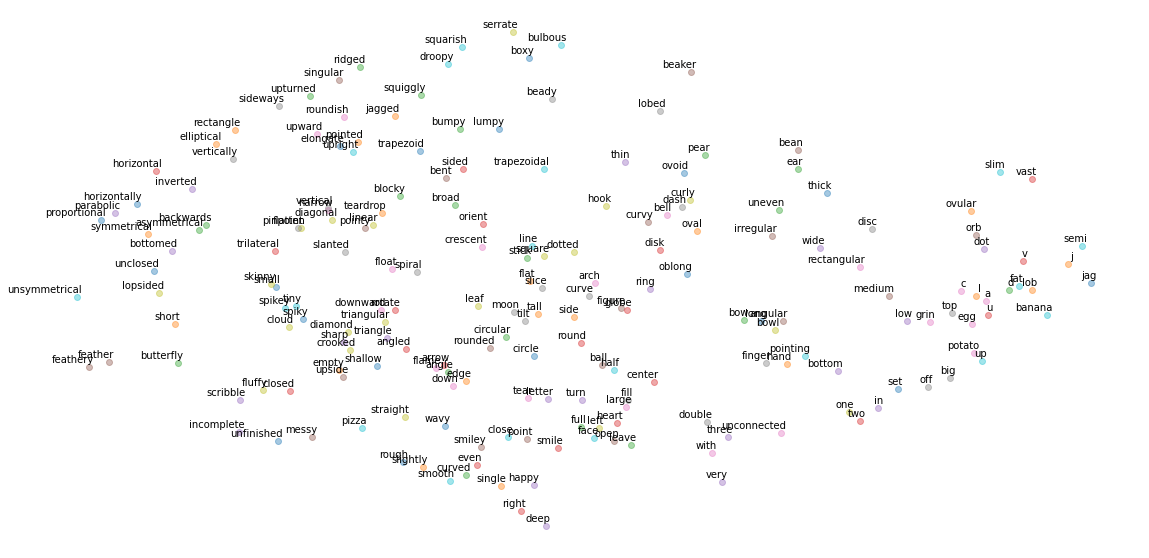

In [16]:
x = []
y = []
for value in clip_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(20,10))
for i in range(len(x)):
    plt.scatter(x[i],y[i],alpha=0.4)
    plt.annotate(common_words[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 fontsize=10,
                )
plt.axis("off") 
plt.show()

# Pair dfn

In [ ]:
dfs, selected_pairss, df_inputs, df_idx_to_task_idxs = \
    rd.compile_face_dfs()

dfn = rd.new_df_pair(dfs, df_idx_to_task_idxs, skip=[0])
dfn.head()

In [ ]:
escape_list = ["shaped", "shape", "and", "like", "sized"]

for i in range(1,3):
    i = str(i)
    dfn['tokenized_{}'.format(i)] = dfn['text_{}'.format(i)].apply(
        lambda x: [y.lemma_ for y in nlp(x) if y.text not in escape_list]
    )
    dfn['lower_{}'.format(i)] = dfn['tokenized_{}'.format(i)].apply(lambda x: [word.lower() for word in x])
    punc = string.punctuation
    dfn['no_punc_{}'.format(i)] = dfn['lower_{}'.format(i)].apply(
        lambda x: [word for word in x if word not in punc]
    )
    dfn['no_punc_str_{}'.format(i)] = [' '.join(map(str, l)) for l in dfn['no_punc_{}'.format(i)]]

In [ ]:
dfn.to_csv('/raid/xiaoyuz1/amazon_turk/df_all_pair.csv', index=False) 

In [ ]:
print_info(dfp)

In [ ]:

facestr = []
for k,v in CONST.face_part_image_indices.items():
    x = len(v)
    facestr.append(str(x))
print(" & ".join(facestr))

angelstr = []
for k,v in CONST.angel_part_image_indices.items():
    x = len(v)
    angelstr.append(str(x))
print(" & ".join(angelstr))


In [ ]:
for row_idx in dfp[dfp['category'] == 'face'].index:
    row = dfp.iloc[row_idx]
    
    p1,p2 = row['image_1'], row['image_2']
    part_idx = row['part']

    w1 = row['no_punc_str_1']
    w2 = row['no_punc_str_2']
    ws = [w1,w2]
    plt.figure(figsize=(10,5))
    for i,p in enumerate([p1,p2]):
        img = PIL.Image.open('/raid/xiaoyuz1/sketch_datasets/face_images_weight_5_all/{}.png'.format(p))
        plt.subplot(1,2,i+1)
        img = img.convert(mode='RGB')
        plt.imshow(img)
        plt.title("{} {}".format(ws[i], CONST.face_parts_idx_dict[part_idx]))
    plt.savefig('/raid/xiaoyuz1/amazon_turk/results/{}.png'.format(str(row_idx)))

In [9]:
dfo[dfo['category'] == 'angel']

,image_1,worker_id,part,category,time,folder,text_1,tokenized_1,lower_1,no_punc_1,no_punc_str_1
5030,202,A3KP8KFGG6734Q,7,angel,656.2,/raid/xiaoyuz1/amazon_turk/2022_04_05_release,Triangle,['Triangle'],['triangle'],[triangle],triangle
5031,213,A3KP8KFGG6734Q,7,angel,656.2,/raid/xiaoyuz1/amazon_turk/2022_04_05_release,sharp pointy,"['sharp', 'pointy']","['sharp', 'pointy']","[sharp, pointy]",sharp pointy
5032,489,A3KP8KFGG6734Q,5,angel,656.2,/raid/xiaoyuz1/amazon_turk/2022_04_05_release,triangle,['triangle'],['triangle'],[triangle],triangle
5033,639,A3KP8KFGG6734Q,5,angel,656.2,/raid/xiaoyuz1/amazon_turk/2022_04_05_release,long oval,"['long', 'oval']","['long', 'oval']","[long, oval]",long oval
5034,24,A3KP8KFGG6734Q,4,angel,656.2,/raid/xiaoyuz1/amazon_turk/2022_04_05_release,small circle,"['small', 'circle']","['small', 'circle']","[small, circle]",small circle
...,...,...,...,...,...,...,...,...,...,...,...
11145,280,APGX2WZ59OWDN,5,angel,239.0,/raid/xiaoyuz1/amazon_turk/2022_04_06_release_3,serrated,['serrate'],['serrate'],[serrate],serrate
11146,736,APGX2WZ59OWDN,7,angel,239.0,/raid/xiaoyuz1/amazon_turk/2022_04_06_release_3,butterfly-shaped,"['butterfly', '-']","['butterfly', '-']",[butterfly],butterfly
11147,477,APGX2WZ59OWDN,7,angel,239.0,/raid/xiaoyuz1/amazon_turk/2022_04_06_release_3,bumpy,['bumpy'],['bumpy'],[bumpy],bumpy
11148,614,APGX2WZ59OWDN,4,angel,239.0,/raid/xiaoyuz1/amazon_turk/2022_04_06_release_3,rectangular,['rectangular'],['rectangular'],[rectangular],rectangular


# (Section)

## get all annotations for a given `(image,part)`

In [ ]:
def get_pair_data(dfn, part_idx_list):
    all_image_indices = np.unique(list(dfn['image_1'].to_numpy()) + list(dfn['image_2'].to_numpy()))
    
    compare_pair = collections.defaultdict(list)
    
    for image_idx in all_image_indices:
        for part_idx in part_idx_list:

            l = []

            dfn_i = dfn[(dfn['part'] == part_idx) & (dfn['image_1'] == image_idx)]
            for i in dfn_i.index:
                row = dfn.iloc[i]

                w1 = row['no_punc_str_1']
                w2 = row['no_punc_str_2']

                l.append((i, row['image_2'], w1,w2))

            dfn_i = dfn[(dfn['part'] == part_idx) & (dfn['image_2'] == image_idx)]
            for i in dfn_i.index:
                row = dfn.iloc[i]

                w1 = row['no_punc_str_1']
                w2 = row['no_punc_str_2']

                l.append((i, row['image_1'], w2,w1))

            if len(l) > 1:
                compare_pair[(image_idx,part_idx)] += l
    return compare_pair

In [ ]:
dfp_face = dfp[dfp['category'] == 'face']
dfp_face = dfp_face.reset_index(drop=True)
compare_pair_face = get_pair_data(dfp_face, CONST.parts_idx_dict.keys())

In [ ]:
print(len(compare_pair_face), 572+572+334+104+572)

In [ ]:
dfp_angel = dfp[dfp['category'] == 'angel']
dfp_angel = dfp_angel.reset_index(drop=True)
compare_pair_angel = get_pair_data(dfp_angel, CONST.angel_parts_idx_dict.keys())

In [ ]:
print(len(compare_pair_angel),779+ 781 +732 + 558 + 80 + 114 + 8)

## opposite annotations

In [ ]:
def get_syn_ant(w):
    synonyms = []
    antonyms = []

    for syn in wordnet.synsets(w):
        for l in syn.lemmas():
            synonyms.append(l.name())
            if l.antonyms():
                antonyms.append(l.antonyms()[0].name())
    return list(set(synonyms)), list(set(antonyms))


wl_list = set()
# for obj, count in all_pair_counter.most_common():
for obj in ks_sorted[::-1][:150]:
    L = np.asarray(all_pair_dict[obj])
    s1,a1 = get_syn_ant(obj.x)
    s2,a2 = get_syn_ant(obj.y)
    for w in a1:
        wl_list.add((obj.x,w))
    for w in a2:
        if "_" in w:
            for wi in w.split("_"):
                wl_list.add((obj.y,wi))
        wl_list.add((obj.y,w))

wl_list = [Pair(p) for p in wl_list]
wl_list = collections.Counter(wl_list)

In [ ]:
problem = []

In [ ]:
for k,v in compare_pair.items():
    w1s = []
    w2s = []
    for _,_,w1,w2 in v:
        w1s += w1.split(" ")
        w2s += w2.split(" ")
    w1s = list(set(w1s))
    add = False
    for wl in wl_list:
        all_in = True
        for w in [wl.x, wl.y]:
            if w not in w1s:
                all_in = False
        if all_in:
            problem.append((k, (wl.x,wl.y)))

In [ ]:
problem_unique = list(set([(p1,part_idx) for (p1,part_idx),wl in problem]))
print(len(problem_unique))

In [ ]:
for (p1,part_idx),wl in problem:
    print("\n\n",p1,rd.part_idx_to_words[part_idx],wl)
    for _,p2,w1,w2 in compare_pair[(p1,part_idx)]:
        ws = [w1,w2]
        plt.figure(figsize=(10,5))
        for i,p in enumerate([p1, p2]):
            img = PIL.Image.open(
            '/raid/xiaoyuz1/sketch_datasets/face_images_weight_5_all/{}.png'.format(p))
            plt.subplot(1,2,i+1);
            img = img.convert(mode='RGB')
            plt.imshow(img)
            plt.title("{} {}".format(ws[i], rd.part_idx_to_words[part_idx]))
        plt.show()

## synonym according to synset and GloVE

In [48]:
c = num_unique_words(dfo)

In [89]:
with open("/raid/xiaoyuz1/amazon_turk/unique_words.pickle", "wb+") as f:
    pickle.dump(c, f)

In [71]:
wn.synsets('small',pos=wn.ADJ)

[Synset('small.a.01'),
 Synset('minor.s.10'),
 Synset('little.s.03'),
 Synset('small.s.04'),
 Synset('humble.s.01'),
 Synset('little.s.07'),
 Synset('little.s.05'),
 Synset('small.s.08'),
 Synset('modest.s.02'),
 Synset('belittled.s.01')]

In [76]:
wn.synsets('big')[1].path_similarity(wn.synsets('small',pos=wn.ADJ)[0])

0.3333333333333333

In [30]:
glovemodel.similarity("linear", "open")

0.2722421

In [53]:
synset_info = []
for k,v in c.items():
    synset_info.append(len(wn.synsets(k)))
synset_info = np.asarray(synset_info)

In [54]:
synset_info

array([ 5, 36,  2, ...,  0, 11,  3])

In [55]:
print(np.sum(synset_info < 1))

180


In [56]:
synset_info.shape

(1450,)

In [25]:
np.asarray(list(c.keys()))[np.asarray(synset_info) == 0]

array(['shorty', 'spikey', 'pointy', 'smirky', 'swirly', 'circulur',
       'slitte', 'unclosed', 'ovoloid', 'zagged', 'oblongated', 'with',
       'veritcal', 'the', 'squiggled', 'teethless', 'pupile', 'bosy',
       'rightward', 'leftward', 'dotlike', 'hatlike', 'poofy', 'drapy',
       'elatedly', 'spkey', 'lopside', 'unshade', 'snuby', 'pupilless',
       'sahpe', 'than', 'bente', 'lindear', 'downturne', 'recangular',
       'uncentere', ' ', 'slitted', 'to', 'rectuangular', 'squircle',
       'ovalish', 'assymmetrical', 'semioval', 'of', 'anglular',
       'checkmark', 'ovaloid', 'ovaltine', 'dumple', 'oble',
       'superellipse', 'reuleaux', 'pinpricke', 'masklike', 'multi',
       'stright', 'similing', 'scribbly', 'bullseye', 'pupille', '  ',
       'unsmile', 'frowny', 'triangularly', 'cartoonishly',
       'microminiature', 'snaggle', 'toothe', 'monolid', 'browe',
       'verticall', 'heptagonal', 'downbend', 'whirly', 'jaggedy',
       'eliptical', 'cirlular', 'trapeziodal'

In [29]:
np.sum(np.asarray([y for (x,y) in c.most_common()]) <= 1)

650

# Create Splits

In [ ]:
import random
def split_list(L):
    L.sort()  
    random.seed(1028)
    random.shuffle(L) 

    split_1 = int(0.7 * len(L))
    split_2 = int(0.8 * len(L))
    train_L = L[:split_1]
    dev_L = L[split_1:split_2]
    test_L = L[split_2:]
    return train_L,dev_L,test_L

def add_split(df):
    all_split = ["train"] * len(df)
    
    for cat,parts_idx_dict in [('face', CONST.face_parts_idx_dict), ('angel', CONST.angel_parts_idx_dict)]:
    
        for k in parts_idx_dict.keys():
            df_part = df[(df['category'] == cat) & (df['part'] == k)]
            df_indices = df_part.index.tolist()
            tr,de,te = split_list(df_indices)
            for i in tr:
                all_split[i] = "train"
            for i in de:
                all_split[i] = "dev"
            for i in te:
                all_split[i] = "test"
    
    df['split'] = all_split
    return df

In [ ]:
def print_split_info(df):
    
    for s in ['train','dev','test']:
        split_num = len(df[(df['split'] == s)])
        print("all {}: total={}, perc={:.2f}".format(s,split_num,split_num/len(df)))
    
    for cat in ['face','angel']:
        print("\n")
        total = len(df[(df['category'] == cat)])
        for s in ['train','dev','test']:
            split_num = len(df[(df['category'] == cat) & (df['split'] == s)])
            print("{} {}: total={}, perc={:.2f}".format(cat,s,split_num,split_num/total))

In [ ]:
dfo = add_split(dfo)

In [ ]:
print_split_info(dfo)

In [ ]:
dfp = add_split(dfp)
print_split_info(dfp)

In [ ]:
dfp.to_csv('/raid/xiaoyuz1/amazon_turk/df_all_pair_withsplit.csv', index=False) 

# CLIP Classification Table

### print parameters

In [ ]:
for k,v in model.state_dict().items():
    if (k.startswith("visual.transformer") or k.startswith("visual")):
        print(k, v.shape)

In [ ]:
# import torch
# for partial_path in os.listdir(root_folder):
#     if partial_path.endswith(".pickle"):
#         acc_path_name = os.path.join(root_folder ,partial_path)
#         torch_path_name = acc_path_name.replace("pickle","pt")
#         if not os.path.exists(torch_path_name):
#             continue
        
#         checkpoint = torch.load(torch_path_name)
#         args = checkpoint['args']
        
#         with open(acc_path_name, 'rb') as f:
#             _, final_accs, preds, gts = pickle.load(f)
#             with open(acc_path_name, 'wb+') as fw:
#                 pickle.dump((args['TRAIN_CATEGORY'], final_accs, preds, gts), fw)

### fine-tuning results compiled

In [4]:
root_folder = '/raid/xiaoyuz1/clip_model_checkpoint'

data = {
    'name' : [],
    'train_cat' : [],
    'face_test' : [],
    'angel_test' : [],
    'face_dev' : [],
    'angel_dev' : [],
    'train' : [],
}

data = {
    'name' : [],
    'train_cat' : [],
    'face_test' : [],
    'face_dev' : [],
    'angel_test' : [],
    'angel_dev' : [],
    'train' : [],
}

for partial_path in os.listdir(root_folder):
    if partial_path.endswith(".pickle"):
        acc_path_name = os.path.join(root_folder ,partial_path)
        torch_path_name = acc_path_name.replace("pickle", "pt")
        if not os.path.exists(torch_path_name):
            continue
        
        with open(acc_path_name, 'rb') as f:
            train_cat, final_accs, _, _ = pickle.load(f)
            try:
                data['face_test'].append(final_accs['test']['face'])
                data['angel_test'].append(final_accs['test']['angel'])
                data['face_dev'].append(final_accs['dev']['face'])
                data['angel_dev'].append(final_accs['dev']['angel'])
                data['train'].append(final_accs['train'])
                data['name'].append(partial_path.split(".")[0])
                
                data['train_cat'].append(" ".join(train_cat))
                
            except:
                print(partial_path)



In [5]:
# fzs = open('/raid/xiaoyuz1/clip_model_checkpoint/old/zs.pickle', 'rb')
# zs_file = pickle.load(fzs)
# fzs.close()
# print(len(zs_file))

In [6]:
with open('/raid/xiaoyuz1/clip_model_checkpoint/old/zs.pickle', 'rb') as f:
    train_cat, final_accs, _, _ = pickle.load(f)
    try:
        data['face_test'].append(final_accs['test']['face'])
        data['angel_test'].append(final_accs['test']['angel'])
        data['face_dev'].append(final_accs['dev']['face'])
        data['angel_dev'].append(final_accs['dev']['angel'])
        data['train'].append(final_accs['train'])
        data['name'].append("zs")

        data['train_cat'].append("none")

    except:
        print(partial_path)

In [7]:
dfacc = pd.DataFrame.from_dict(data)

In [8]:
dfacc

,name,train_cat,face_test,face_dev,angel_test,angel_dev,train
0,giddy-field-6,face,0.671937,0.673307,0.591205,0.578176,0.773322
1,resilient-puddle-23,face,0.671937,0.699203,0.583062,0.568404,0.780432
2,atomic-meadow-1,face angel,0.627470,0.623506,0.623779,0.620521,0.649602
3,visionary-sun-30,angel,0.581028,0.609562,0.671824,0.705212,0.942029
4,fiery-butterfly-21,face angel,0.722332,0.699203,0.710098,0.716612,0.856685
5,snowy-dawn-11,face angel,0.714427,0.701195,0.673453,0.693811,0.800616
6,snowy-dawn-11_2,face angel,0.708498,0.683267,0.678339,0.685668,0.871055
7,happy-wind-24,face,0.712451,0.715139,0.573290,0.563518,0.837031
8,pleasant-blaze-16_2,face,0.648221,0.689243,0.576547,0.566775,0.724972
9,easy-brook-22,face,0.704545,0.703187,0.577362,0.542345,0.943686


In [9]:
dfacc[dfacc.train_cat.apply(lambda x: x == "face")].sort_values(
    by=['angel_dev'],ascending=False)

,name,train_cat,face_test,face_dev,angel_test,angel_dev,train
17,whole-surf-12_2,face,0.662055,0.687251,0.584691,0.581433,0.744312
0,giddy-field-6,face,0.671937,0.673307,0.591205,0.578176,0.773322
16,fearless-salad-4,face,0.700593,0.685259,0.580619,0.574919,0.834755
14,woven-lake-9,face,0.596838,0.615538,0.572476,0.570033,0.617179
1,resilient-puddle-23,face,0.671937,0.699203,0.583062,0.568404,0.780432
8,pleasant-blaze-16_2,face,0.648221,0.689243,0.576547,0.566775,0.724972
15,pleasant-blaze-16,face,0.667984,0.695219,0.574919,0.565147,0.751991
7,happy-wind-24,face,0.712451,0.715139,0.573290,0.563518,0.837031
13,vibrant-sea-29,face,0.653162,0.703187,0.565961,0.550489,0.805461
11,jumping-dawn-31,face,0.694664,0.733068,0.586319,0.547231,0.996587


In [10]:
dfacc[dfacc.train_cat.apply(lambda x: x == "angel")].sort_values(
    by=['face_dev'],ascending=False)

,name,train_cat,face_test,face_dev,angel_test,angel_dev,train
3,visionary-sun-30,angel,0.581028,0.609562,0.671824,0.705212,0.942029
12,resilient-sponge-26,angel,0.570158,0.591633,0.666124,0.643322,0.872604


In [11]:
dfacc[dfacc.train_cat.apply(lambda x: (x == "face angel"))].sort_values(
    by=['angel_test'],ascending=False)

,name,train_cat,face_test,face_dev,angel_test,angel_dev,train
19,exalted-breeze-19,face angel,0.725296,0.717131,0.721498,0.708469,0.915063
4,fiery-butterfly-21,face angel,0.722332,0.699203,0.710098,0.716612,0.856685
18,pleasant-tree-10,face angel,0.743083,0.717131,0.703583,0.710098,0.928406
10,eternal-aardvark-20,face angel,0.711462,0.693227,0.698697,0.724756,0.939441
6,snowy-dawn-11_2,face angel,0.708498,0.683267,0.678339,0.685668,0.871055
5,snowy-dawn-11,face angel,0.714427,0.701195,0.673453,0.693811,0.800616
2,atomic-meadow-1,face angel,0.627470,0.623506,0.623779,0.620521,0.649602


### word embeddings and cosine similarity

In [34]:
dfp = get_df()
template_1,template_2 = template[0]
dfp['caption_1'] = dfp.apply(template_1, axis=1)
dfp['caption_2'] = dfp.apply(template_2, axis=1)

In [15]:
c = None
with open("/raid/xiaoyuz1/amazon_turk/unique_words.pickle", "rb") as f:
    c = pickle.load(f)

In [16]:
save_root = "/raid/xiaoyuz1/amazon_turk/word_embeddings"

In [28]:
word_feat = calculate_word_embeddings(
    list(c.keys()), \
    glovemodel, \
    device, \
    tokenizer = None, \
    path = os.path.join(save_root, "glove.pickle"), \
    save_to_path = True, \
    model_type = "glove",
)

Extracting word embeddings using Glove Gensim


In [23]:
word_feat = calculate_word_embeddings(
    list(c.keys()), \
    model, \
    device, \
    tokenizer = None, \
    path = os.path.join(save_root, "zs.pickle"), \
    save_to_path = True, \
    model_type = "clip"
)

Extracting word embeddings using CLIP


In [26]:
word_feat = calculate_word_embeddings(
    list(c.keys()), \
    model, \
    device, \
    tokenizer = None, \
    path = os.path.join(save_root, "pleasant-tree-10.pickle"), \
    save_to_path = True, \
    model_type = "clip"
)

Extracting word embeddings using CLIP


In [24]:
word_feat = calculate_word_embeddings(
    list(c.keys()), \
    bert_model, \
    device, \
    tokenizer = bert_tokenizer, \
    path = os.path.join(save_root, "bert.pickle"), \
    save_to_path = True, \
    model_type = "bert"
)

Extracting word embeddings using bert


In [107]:
class WordEmb:
    def __init__(self, wordlist, sim):
        self.wordlist = list(wordlist)
        self.sim = torch.tensor(sim)
    
    def similarity(self, w1, w2):
        if w1 not in self.wordlist:
            raise ValueError("{} is not in the word list!".format(w1))
        if w2 not in self.wordlist:
            raise ValueError("{} is not in the word list!".format(w2))
        i = self.wordlist.index(w1)
        j = self.wordlist.index(w2)
        return self.sim[i][j].item()
    
    def most_similar(self, w, topn=10, different=False):
        if w not in self.wordlist:
            raise ValueError("{} is not in the word list!".format(w))

        i = self.wordlist.index(w)
        row = self.sim[i]
        if different:
            top_indices = torch.argsort(row)[:topn]
        else:
            top_indices = torch.argsort(row)[-(topn+1):-1]
            top_indices = list(top_indices)[::-1]

        top_list = zip(
            [self.wordlist[j] for j in top_indices],
            [row[j].item() for j in top_indices],
        )
        return list(top_list)

In [108]:
obj = WordEmb(wordlist, sim)

<ipython-input-107-d90226dc5c01>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sim = torch.tensor(sim)


In [110]:
wordlist.index("circular"),wordlist.index("egg")

(11, 113)

In [111]:
sim[11][113],sim[113][11]

(tensor(0.7329, dtype=torch.float16), tensor(0.7329, dtype=torch.float16))

In [115]:
sim[11].mean()

tensor(0.7104, dtype=torch.float16)

### distance

#### contrastive word pairs

In [22]:
all_pair_df = rd.all_pair_combination(dfp, wrong_rows=[])

In [23]:
all_pair_df

,word1,word2,total_occurrence,correct#,correct%,correct_row_idx,incorrect_row_idx
0,small,large,228,228,1.0,"[1, 7, 101, 145, 204, 220, 260, 275, 382, 400,...",[]
1,circular,oval,142,142,1.0,"[4, 24, 119, 149, 199, 200, 214, 375, 454, 531...",[]
2,wide,narrow,124,124,1.0,"[22, 82, 111, 149, 229, 588, 589, 660, 726, 80...",[]
3,small,round,112,112,1.0,"[46, 101, 145, 220, 260, 395, 400, 470, 635, 7...",[]
4,wide,small,108,108,1.0,"[2, 57, 100, 242, 340, 367, 633, 642, 666, 702...",[]
...,...,...,...,...,...,...,...
9818,wavy,perky,1,1,1.0,[6],[]
9819,oval,surprised,1,1,1.0,[5],[]
9820,horizontal,surprised,1,1,1.0,[5],[]
9821,large,surprised,1,1,1.0,[5],[]


In [15]:
all_pair_df = pd.read_csv('/raid/xiaoyuz1/amazon_turk/df_all_pair_word_pairs.csv')

In [ ]:
all_pair_df = calculate_word_similarity_clip(
    all_pair_df, model_face, device, column_name = "sim_clip_face", cosine_sim = False)
all_pair_df = calculate_word_similarity_clip(
    all_pair_df, model, device, column_name = "sim_clip_face_angel", cosine_sim = False)
all_pair_df = calculate_word_similarity_bert(
    all_pair_df, bert_model, bert_tokenizer, device, \
    column_name = "sim_bert", cosine_sim = False)
all_pair_df = calculate_word_similarity_glove(
    all_pair_df, glovemodel, device, \
    column_name = "sim_glove", cosine_sim = False)

In [11]:
all_pair_df = calculate_word_similarity_clip(
    all_pair_df, modelzs, device, column_name = "cosine_sim_clip", cosine_sim = True)

In [ ]:
all_pair_df = calculate_word_similarity_clip(
    all_pair_df, model_face, device, column_name = "cosine_sim_clip_face", cosine_sim = True)
all_pair_df = calculate_word_similarity_clip(
    all_pair_df, model, device, column_name = "cosine_sim_clip_face_angel", cosine_sim = True)
all_pair_df = calculate_word_similarity_bert(
    all_pair_df, bert_model, bert_tokenizer, device, \
    column_name = "cosine_sim_bert", cosine_sim = True)
all_pair_df = calculate_word_similarity_glove(
    all_pair_df, glovemodel, device, \
    column_name = "cosine_sim_glove", cosine_sim = True)

In [21]:
print(all_pair_df.columns)
cols = ['word1', 'word2', \
        'cosine_sim_bert', \
        'cosine_sim_clip', \
        'cosine_sim_clip_face', \
        'cosine_sim_clip_face_angel', \
        'cosine_sim_glove', \
        'sim_bert', \
        'sim_clip_face', \
        'sim_clip_face_angel', \
        'sim_glove', \
        'total_occurrence', \
        'correct_row_idx', \
       ]

# all_pair_df[cols].head(200).sort_values(by=['cosine_sim_glove'], ascending=False)

Index(['word1', 'word2', 'total_occurrence', 'correct#', 'correct%',
       'correct_row_idx', 'incorrect_row_idx', 'cosine_sim_bert',
       'cosine_sim_clip_face', 'cosine_sim_clip_face_angel', 'sim_clip_face',
       'sim_clip_face_angel', 'sim_glove', 'cosine_sim_glove', 'sim_bert',
       'cosine_sim_clip'],
      dtype='object')


In [14]:
all_pair_df[all_pair_df['cosine_sim_clip_face_angel'] <= all_pair_df['cosine_sim_glove']][cols]

,word1,word2,cosine_sim_bert,cosine_sim_clip,cosine_sim_clip_face,cosine_sim_clip_face_angel,cosine_sim_glove,sim_bert,sim_clip_face,sim_clip_face_angel,sim_glove,total_occurrence,correct_row_idx
0,small,large,0.991273,0.919434,0.878418,0.798340,0.861530,247.298706,91.62500,72.375000,46.466022,228,[ 1 7 101 145 204 220 260 275 382 ...
10,short,long,0.916821,0.835938,0.787598,0.697754,0.820970,218.175629,74.43750,58.750000,41.230141,68,[ 102 128 138 148 218 238 243 268 288 ...
130,oval,rectangular,0.986025,0.790527,0.749023,0.686035,0.690008,252.116577,66.56250,51.281250,33.620979,19,[1067 1944 2014 2018 2205 2208 2226 2278 2488 ...
280,thick,thin,0.993032,0.870605,0.780273,0.645996,0.756829,222.410522,66.43750,43.281250,39.871071,11,[ 328 398 423 463 1877 2694 3106 3134 4411 ...
285,vertical,horizontal,0.974451,0.881348,0.784180,0.713867,0.926618,230.793655,65.37500,49.125000,45.917988,11,[ 236 984 1494 1602 1611 1613 1706 1790 1879 ...
381,high,low,0.974972,0.877930,0.831055,0.755859,0.781333,206.060699,99.75000,75.562500,45.875874,8,[1517 2580 3307 3693 3709 4799 5495 5498]
675,round,round,1.000000,0.995605,0.993652,0.994629,1.000000,225.575897,100.75000,94.750000,48.965923,5,[ 920 3071 3715 4770 4774]
781,circular,circular,1.000000,0.994141,0.994629,0.994629,1.000000,256.345093,106.62500,99.312500,43.917061,4,[3017 4067 4949 5170]
889,curve,curve,1.000000,0.991699,0.994141,0.995117,1.000000,263.405731,103.68750,88.437500,48.268700,4,[ 922 3979 5036 5139]
1052,two,three,0.992689,0.927246,0.912598,0.899902,0.961781,254.128830,108.50000,96.312500,48.476974,3,[3055 3753 4696]


In [16]:
for c in cols:
    if 'sim' in c:
        if 'glove' in c:
            print(c, all_pair_df[c][all_pair_df[c] >= -1].mean())
        else:
            print(c, all_pair_df[c].mean())

cosine_sim_bert 0.924697277390713
cosine_sim_clip 0.8327558925799144
cosine_sim_clip_face 0.7521660241747684
cosine_sim_clip_face_angel 0.6914020807452058
cosine_sim_glove 0.25908817080234237
sim_bert 220.74610747250256
sim_clip_face 74.52051705817978
sim_clip_face_angel 59.0103953253843
sim_glove 12.885511423475629


In [30]:
cols = ['word1', 'word2', \
        'total_occurrence', \
        'cosine_sim_bert', \
        'cosine_sim_clip', \
        'cosine_sim_clip_face', \
        'cosine_sim_clip_face_angel', \
        'cosine_sim_glove', \
        'sim_bert', \
        'sim_clip_face', \
        'sim_clip_face_angel', \
        'sim_glove', \
       ]
all_pair_df[cols].to_csv('/raid/xiaoyuz1/amazon_turk/df_all_pair_word_pairs_sim.csv', index=False)

In [5]:
all_pair_df = pd.read_csv('/raid/xiaoyuz1/amazon_turk/df_all_pair_word_pairs_sim.csv')

In [11]:
for i in range(20):
    row = all_pair_df.iloc[i]
    latex_str = "{} & {} & {}".format(row['word1'], row['word2'], row['total_occurrence'])
    print(latex_str+ r" \\")

small & large & 228 \\
circular & oval & 142 \\
wide & narrow & 124 \\
small & round & 112 \\
wide & small & 108 \\
oval & small & 100 \\
circular & small & 94 \\
oval & round & 92 \\
close & open & 83 \\
big & small & 71 \\
short & long & 68 \\
curve & wide & 68 \\
thin & wide & 61 \\
open & small & 60 \\
oval & wide & 60 \\
large & round & 55 \\
round & uneven & 53 \\
oval & open & 51 \\
open & circular & 47 \\
curve & small & 46 \\


In [59]:
glove_bigger = np.sum(
    (all_pair_df['cosine_sim_glove'] >= all_pair_df['cosine_sim_clip_face_angel'])
)
print(glove_bigger, glove_bigger / len(all_pair_df))

33 0.0033594624860022394


In [61]:
all_pair_df[all_pair_df['cosine_sim_clip_face_angel'] <= all_pair_df['cosine_sim_glove']][cols]

In [55]:
np.sum(
    (all_pair_df['cosine_sim_bert'] > all_pair_df['cosine_sim_clip_face']) & 
    (all_pair_df['cosine_sim_clip_face'] > all_pair_df['cosine_sim_clip_face_angel'])
) / len(all_pair_df)

0.8355899419729207

In [32]:
dfnii = all_pair_df[(all_pair_df['word1'] == 'large') & (all_pair_df['word2'] == 'tiny')]
dfnii

,word1,word2,total_occurrence,correct#,correct%,correct_row_idx,incorrect_row_idx
24,large,tiny,43,43,1.0,"[131, 190, 195, 246, 360, 620, 696, 736, 958, ...",[]


131
large nose
face 665
tiny nose
face 282


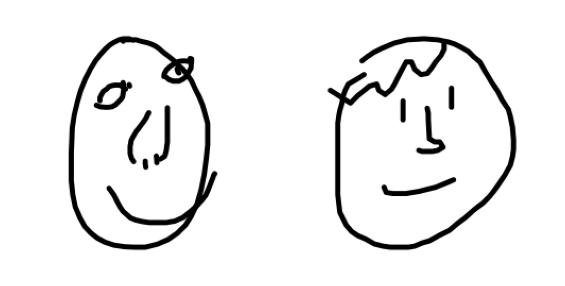

190
tiny pinpoint eyes
face 34
large circular eyes
face 84


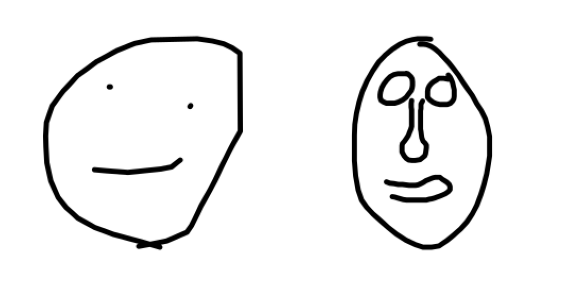

195
large circular eyes
face 19
tiny solid eyes
face 102


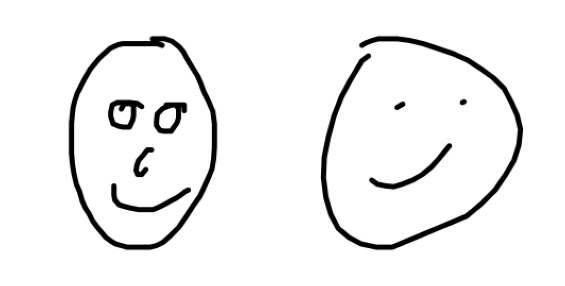

246
tiny pointy nose
face 489
large perky nose
face 340


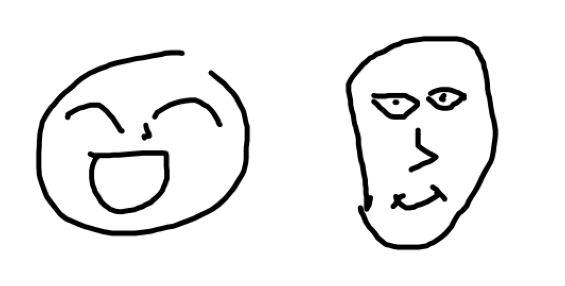

360
tiny eyes
face 784
large eyes
face 550


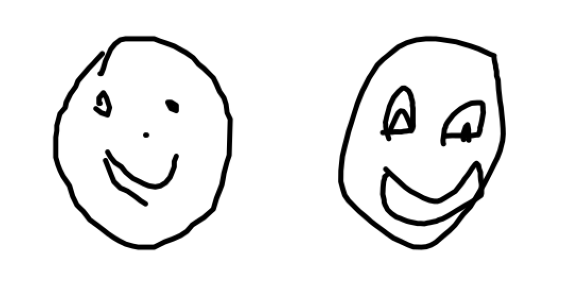

620
large spiraling eyes
face 37
tiny slot eyes
face 176


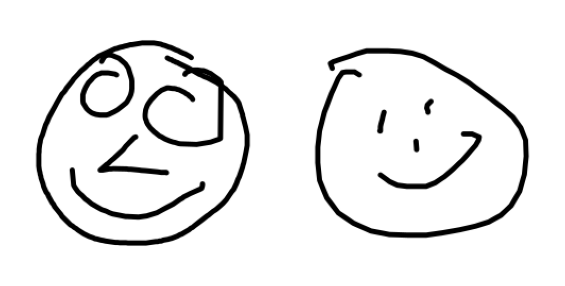

696
tiny dot eyes
face 255
large uneven sloppy eyes
face 633


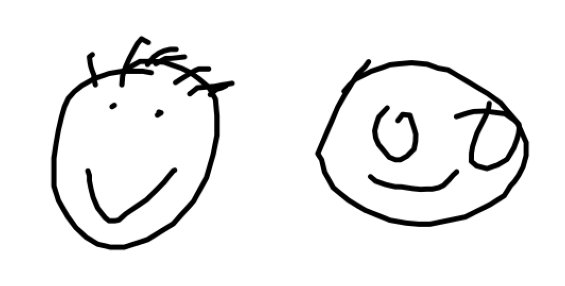

736
tiny eyes
face 296
large eyes
face 214


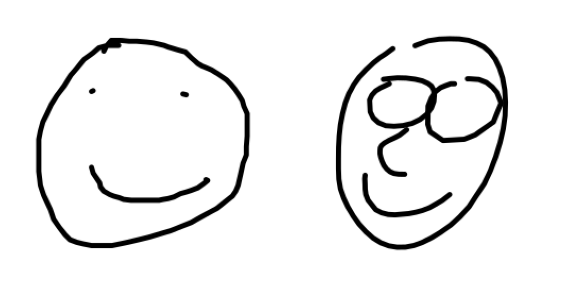

958
tiny cheerful mouth
face 80
big large smile mouth
face 211


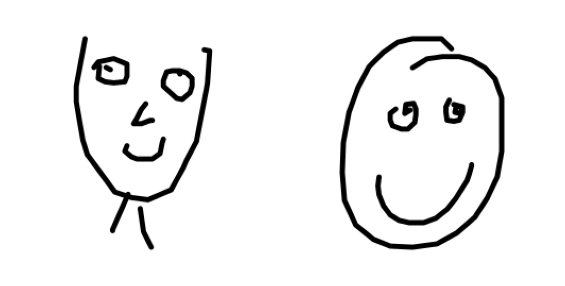

988
tiny uneven dotted eyes
face 165
large circular eyes
face 448


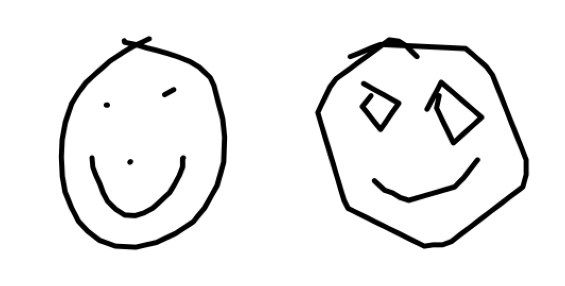

1020
tiny vertical eyes
face 688
large oval eyes
face 86


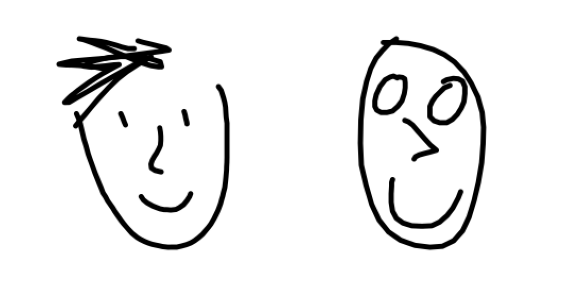

1104
tiny slitte eyes
face 335
large line eyes
face 74


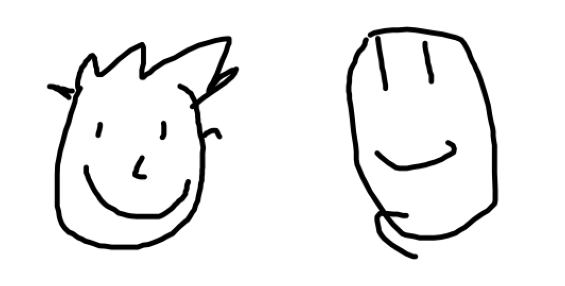

1113
tiny l nose
face 111
large l nose
face 545


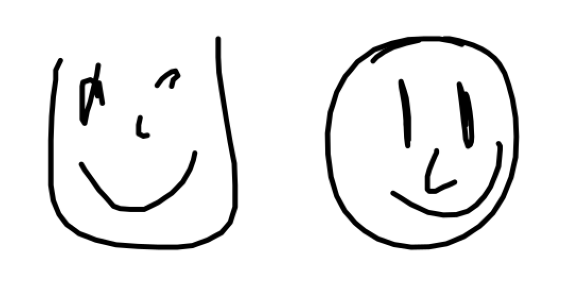

1292
big large nose
face 787
small tiny nose
face 592


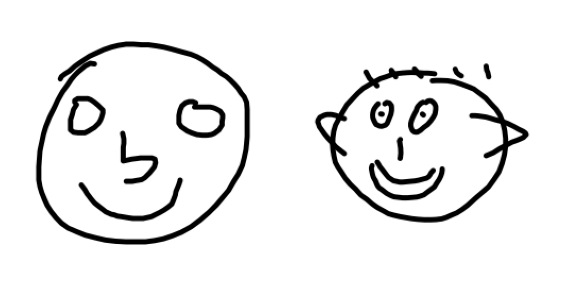

1451
dot tiny eyes
face 653
large tower eyes
face 337


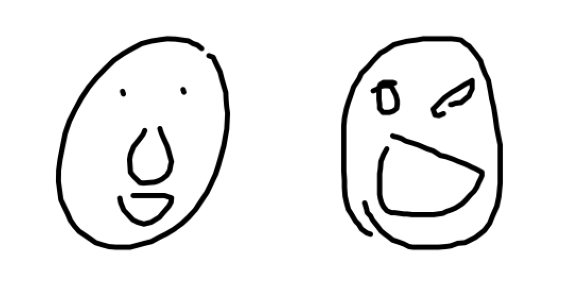

1568
tiny wide set eyes
face 193
large oval eyes
face 437


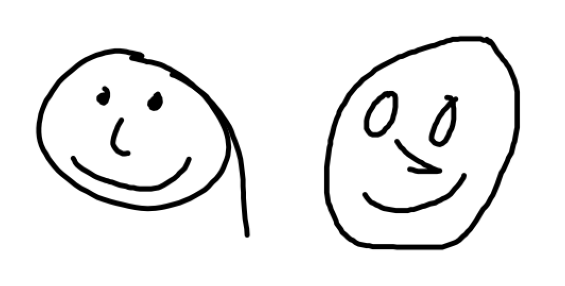

1574
tiny lopsided eyes
face 675
large angular eyes
face 484


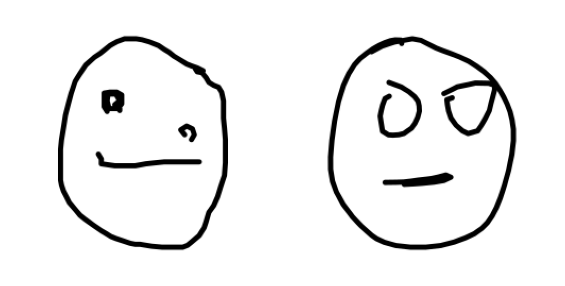

1676
tiny sideways eyes
face 176
large wide open eyes
face 145


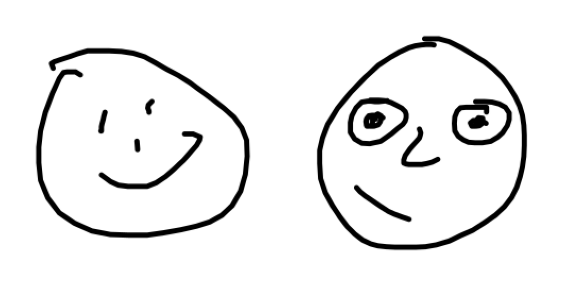

1708
large vertical eyes
face 364
tiny dot eyes
face 92


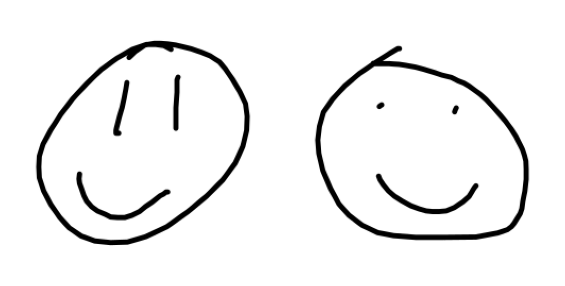

1868
large thin vertical eyes
face 607
tiny dotted eyes
face 525


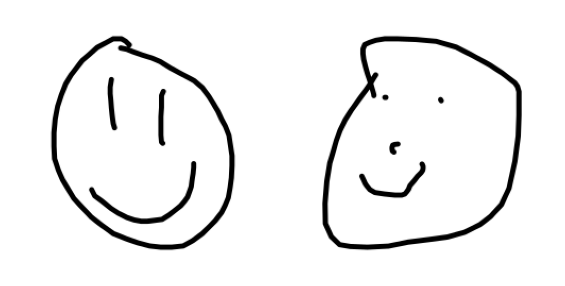

2064
tiny eyes
face 714
large eyes
face 470


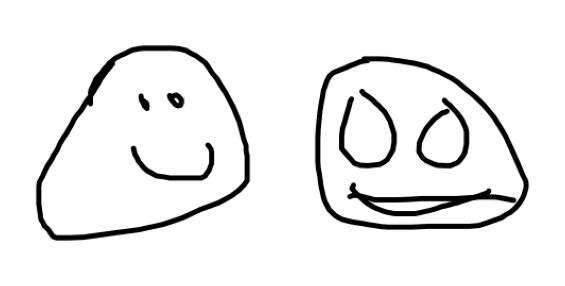

2092
large mouth
face 114
tiny mouth
face 599


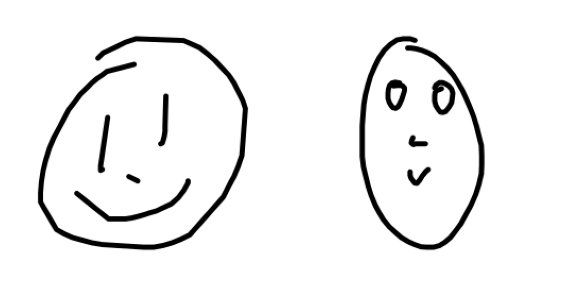

2132
large mouth
face 469
tiny mouth
face 438


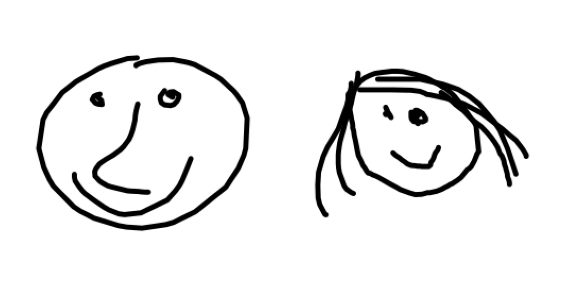

2506
tiny thin mouth
face 642
large wide mouth
face 335


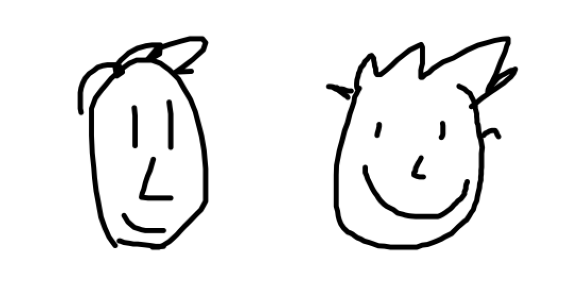

2594
large disk eyes
angel 182
tiny small eyes
angel 482


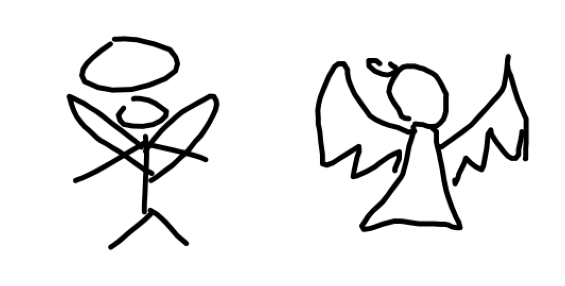

2934
large eyes
angel 6
tiny eyes
angel 483


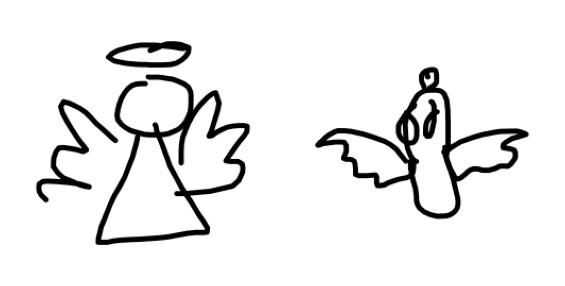

3141
tiny wide curved eyes
angel 62
large wide curved eyes
angel 530


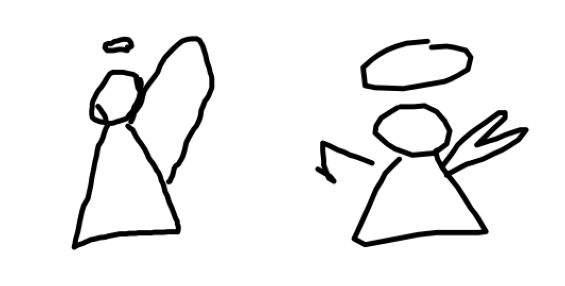

3361
flat tiny eyes
angel 535
egg large eyes
angel 632


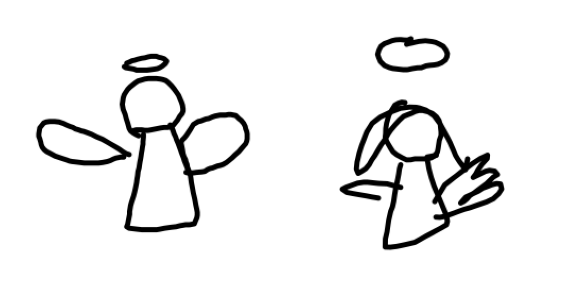

3698
large hair
angel 187
tiny hair
angel 439


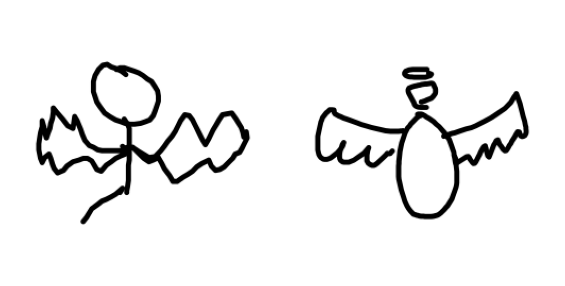

3711
tiny eyes
angel 41
large eyes
angel 509


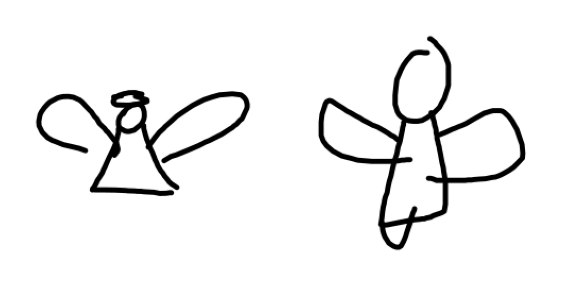

3713
large eyes
angel 109
tiny eyes
angel 157


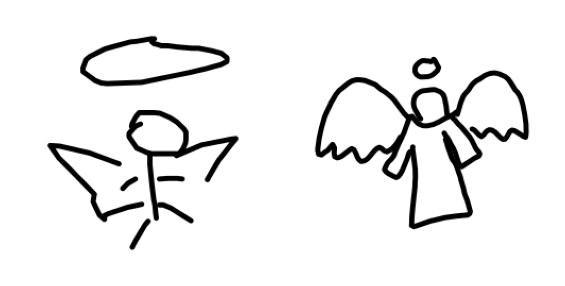

3938
uneven large round hair
angel 71
tiny round hair
angel 615


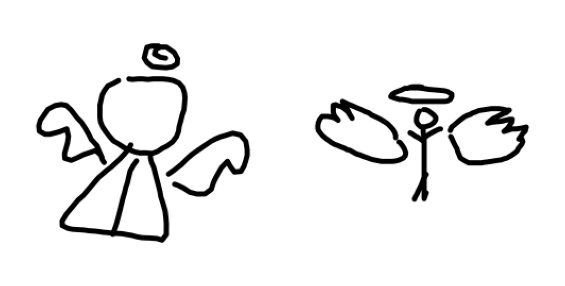

4183
large circular hair
angel 62
tiny oval hair
angel 411


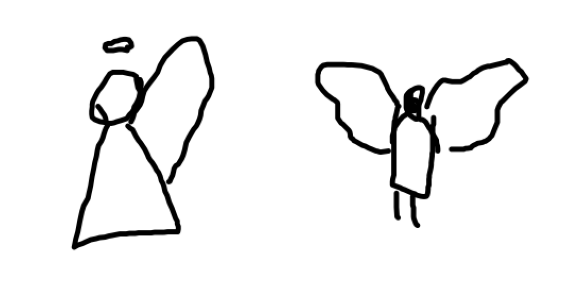

4208
tiny eyes
angel 159
large eyes
angel 530


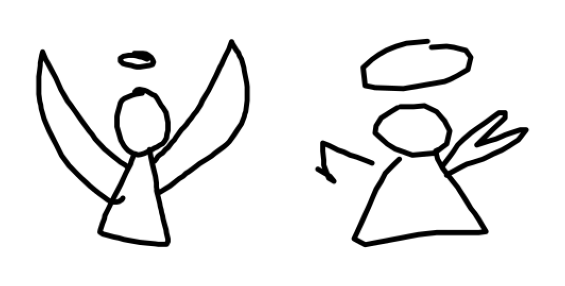

4325
tiny hair
angel 538
large hair
angel 655


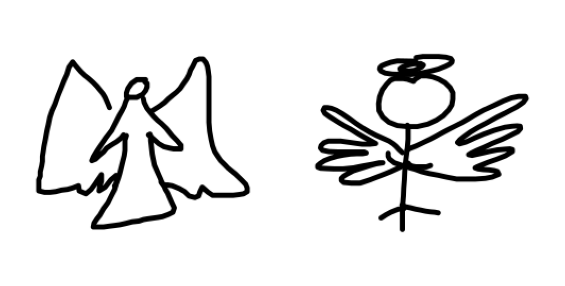

4328
large hair
angel 61
tiny hair
angel 454


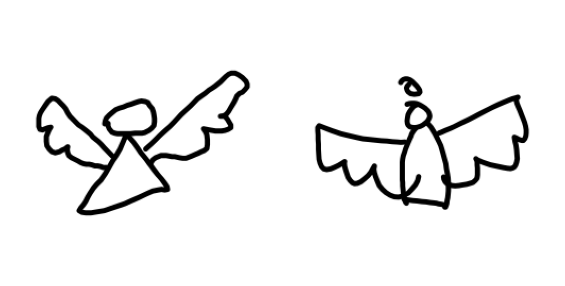

4399
large hair
angel 11
tiny hair
angel 234


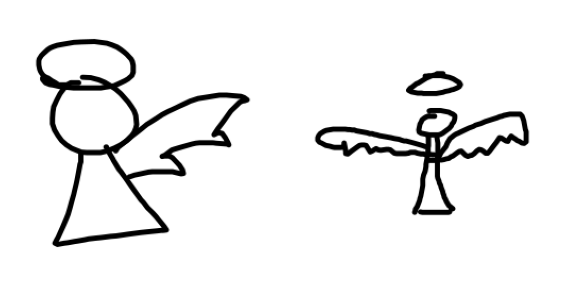

4901
tiny dot nose
angel 49
large circular fill nose
angel 5


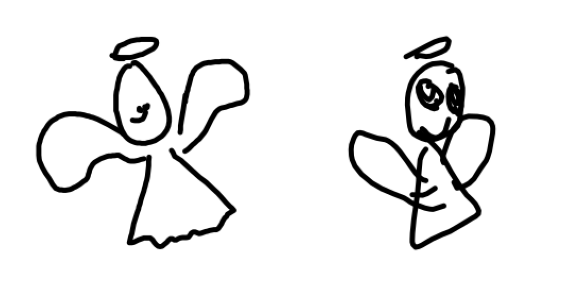

4930
circular round tiny hair
angel 413
egg large hair
angel 666


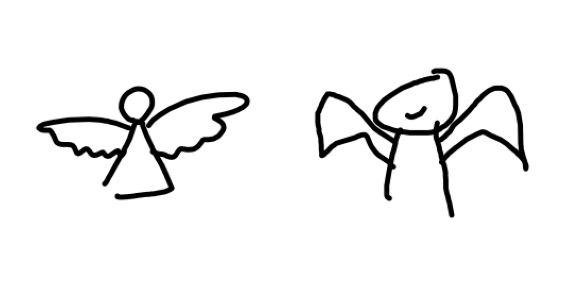

5216
tiny shoe eyes
angel 624
large flattened oval eyes
angel 202


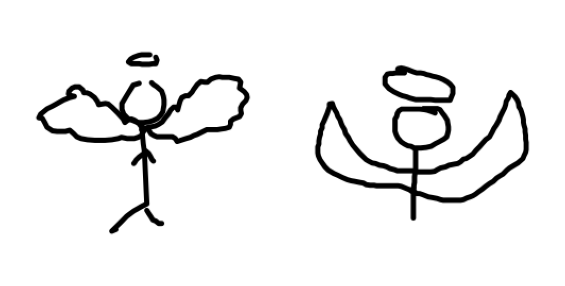

5308
tiny small round hair
angel 600
large oval hair
angel 715


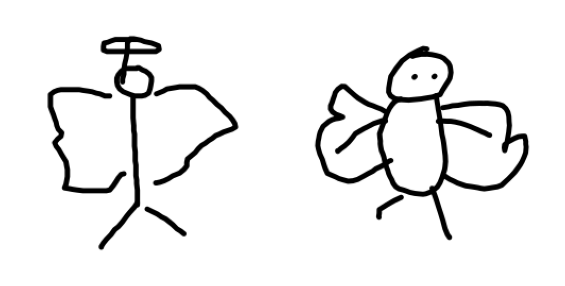

5482
large hair
angel 797
tiny hair
angel 623


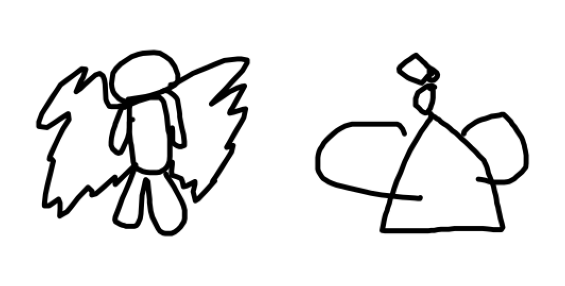

5547
tiny triangular hair
angel 673
diamond large hair
angel 89


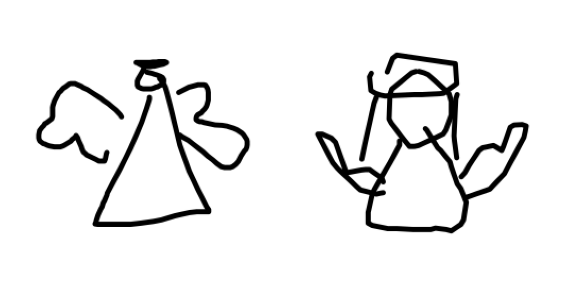

In [33]:
for l in dfnii['correct_row_idx']:
#     l = filter(lambda x: x.strip() !='',[y.strip() for y in l[1:-1].split(" ")])
#     l = list(l)
#     l = [int(x) for x in l]
    for row_idx in l:
        print(row_idx)
        row = dfp.iloc[row_idx]
        
        p1,p2 = row['image_1'], row['image_2']
        part_idx = row['part']
        cat = row['category']

        w1 = row['no_punc_str_1']
        w2 = row['no_punc_str_2']
        # print(w1,", ", w2)
        ws = [w1,w2]
        plt.figure(figsize=(10,5))
        for i,p in enumerate([p1,p2]):
            img = PIL.Image.open('/raid/xiaoyuz1/sketch_datasets/{}_images_weight_5_all/{}.png'.format(cat,p))
            plt.subplot(1,2,i+1)
            img = img.convert(mode='RGB')
            plt.imshow(img)
            
            #plt.title()
            print("{} {}".format(ws[i], CONST.face_parts_idx_dict[part_idx]))
            print(cat,p)
            plt.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

#### percentage change

In [15]:
np.argmax(np.asarray([[0,10],[-1,100]]).reshape((2,2)), axis=1)

array([1, 1])

In [27]:
c2 = 'cosine_sim_clip_face_angel'
c1 = 'cosine_sim_bert'
df = all_pair_df
df_new = df

# df_new = df[['word1','word2','total_occurrence',c1,c2]].copy()
df_new['change%'] = (df_new[c2] - df_new[c1]) / df_new[c1]
df_new['absChange%'] = abs((df_new[c2] - df_new[c1]) / df_new[c1])

In [49]:
df_new[(df_new['word1'] == 'small') & (df_new['word2'] == 'round')]

,word1,word2,total_occurrence,correct#,correct%,correct_row_idx,incorrect_row_idx,cosine_sim_bert,cosine_sim_clip_face,cosine_sim_clip_face_angel,change%,absChange%
3,small,round,112,112,1.0,[ 46 101 145 220 260 395 400 470 635 ...,[],0.971433,0.856445,0.739746,-0.2385,0.2385


In [29]:
df_pos = df_new[df_new['change%'] > 0]
print(len(df_pos))

259


In [30]:
print(df_pos['absChange%'].median())

0.08953857737689182


In [31]:
df_new.iloc[df_pos['absChange%'].sort_values().index.tolist()].tail(100)

,word1,word2,total_occurrence,correct#,correct%,correct_row_idx,incorrect_row_idx,cosine_sim_bert,cosine_sim_clip_face,cosine_sim_clip_face_angel,change%,absChange%
2072,curved,trapezoidal,2,2,1.0,[1867 4602],[],0.613408,0.746094,0.688965,0.123176,0.123176
1982,curved,disconnect,2,2,1.0,[2314 2984],[],0.693727,0.828125,0.780762,0.125459,0.125459
1087,trapezoidal,broad,3,3,1.0,[2742 2900 3503],[],0.640108,0.789062,0.721191,0.126671,0.126671
5889,spot,point,1,1,1.0,[3347],[],0.730059,0.903809,0.826172,0.131651,0.131651
1506,point,sided,2,2,1.0,[4426 5162],[],0.642861,0.857422,0.728027,0.132481,0.132481
9626,gentle,point,1,1,1.0,[188],[],0.635628,0.866699,0.720703,0.133844,0.133844
4859,marshmallow,slightly,1,1,1.0,[4082],[],0.618844,0.804199,0.702637,0.135401,0.135401
2079,scribbled,straight,2,2,1.0,[1822 2084],[],0.644359,0.860840,0.731934,0.135910,0.135910
4519,antler,stick,1,1,1.0,[4296],[],0.585901,0.766113,0.666504,0.137571,0.137571
1891,squiggly,finger,2,2,1.0,[2660 3478],[],0.534279,0.778320,0.608398,0.138727,0.138727


In [48]:
all_pair_s = rd.all_pair_together(dfp)
all_pair_s

,word1,word2,total_occurrence,correct#,correct%,correct_row_idx,incorrect_row_idx
0,small,round,228,228,1.0,"[100, 100, 180, 180, 210, 210, 220, 220, 260, ...",[]
1,small,circular,176,176,1.0,"[206, 206, 240, 240, 792, 792, 796, 796, 864, ...",[]
2,vertical,line,168,168,1.0,"[26, 26, 110, 110, 170, 170, 175, 175, 235, 23...",[]
3,circular,open,150,150,1.0,"[135, 135, 185, 185, 274, 274, 621, 621, 756, ...",[]
4,small,oval,150,150,1.0,"[110, 110, 656, 656, 676, 676, 729, 729, 1160,...",[]
...,...,...,...,...,...,...,...
5744,bumpy,circular,2,2,1.0,"[24, 24]",[]
5745,perky,vertical,2,2,1.0,"[6, 6]",[]
5746,wavy,small,2,2,1.0,"[6, 6]",[]
5747,asymmetrical,surprised,2,2,1.0,"[5, 5]",[]


In [54]:
all_pair_s[(all_pair_s['word1'] == 'leftward') & (all_pair_s['word2'] == 'pointing')]

,word1,word2,total_occurrence,correct#,correct%,correct_row_idx,incorrect_row_idx
1691,leftward,pointing,4,4,1.0,"[296, 296, 451, 451]",[]


In [12]:
all_pair_df = rd.all_pair_combination(dfp, wrong_rows=[])

In [15]:
len(all_pair_df)

9823

### wrong rows

In [ ]:
dfii = dfo[(dfo['category'] == 'angel') & (dfo['image_1'] == 93)]
print(len(dfii), len(dfii['worker_id'].unique()))
dfii = dfii.sort_values(by=['part'], ascending=False)
dfii

In [ ]:
row_figsize = 3
column_figsize = 3
num_pngs_per_row = 4

num_images = min(len(dfii), 7 * num_pngs_per_row)
if num_images < len(dfii):
    plot_indices = np.random.choice(np.arange(len(dfii)), num_images)
else:
    plot_indices = np.arange(len(dfii))
    
num_rows = num_images // num_pngs_per_row
if num_rows * num_pngs_per_row < num_images:
    num_rows += 1

fig = plt.figure(figsize=(num_pngs_per_row * row_figsize, num_rows * column_figsize)) 
fig.patch.set_alpha(1)  

for index,df_idx in enumerate(plot_indices):
    plt.subplot(num_rows, num_pngs_per_row, index+1)
    
    row = dfii.iloc[df_idx]
    idx = row['image_1']
    color_selected_part = [int(row['part'])]
    
    if row['category'] == 'face':
        drawing_raw = CONST.face_json['train_data'][idx]
    else:
        drawing_raw = CONST.angel_json['train_data'][idx]
    image_data = rd.transform_spg_2_svg_png(
        drawing_raw, 
        draw_color = True, 
        stroke_width = 3,
        color_selected = color_selected_part,
    )
    plt.imshow(image_data)
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.close()

In [ ]:
dfo[(dfo['category'] == 'face') & (dfo['part'] == 6)]['no_punc_str_1'].tolist()

In [47]:
dfii = rd.find_one(dfo, 'hook', 'no_punc_1')
# dfii = dfii[(dfii['category'] == 'face') & (dfii['part'] == 6)]
dfii

,image_1,worker_id,part,category,time,folder,text_1,tokenized_1,lower_1,no_punc_1,no_punc_str_1
102,205,AAQREZOK13OV7,1,face,91.0,/raid/xiaoyuz1/amazon_turk/2022_03_21_release,hooked,['hook'],['hook'],[hook],hook
212,260,A38DXFI1TZA295,1,face,549.4,/raid/xiaoyuz1/amazon_turk/2022_03_21_release,fish hook,"['fish', 'hook']","['fish', 'hook']","[fish, hook]",fish hook
373,681,AFU00NU09CFXE,1,face,208.2,/raid/xiaoyuz1/amazon_turk/2022_03_21_release,hook-shaped,"['hook', '-']","['hook', '-']",[hook],hook
563,367,A2541C8MY0BYV3,1,face,129.2,/raid/xiaoyuz1/amazon_turk/2022_03_22_release,hook-shaped,"['hook', '-']","['hook', '-']",[hook],hook
716,331,A2541C8MY0BYV3,4,face,635.2,/raid/xiaoyuz1/amazon_turk/2022_03_22_release,"long, hook-like","['long', ',', 'hook', '-']","['long', ',', 'hook', '-']","[long, hook]",long hook
992,267,A38DXFI1TZA295,1,face,182.4,/raid/xiaoyuz1/amazon_turk/2022_03_22_release,inverted hook,"['inverted', 'hook']","['inverted', 'hook']","[inverted, hook]",inverted hook
1033,392,A3AJJHOAV7WIUQ,1,face,631.0,/raid/xiaoyuz1/amazon_turk/2022_03_22_release,short hook,"['short', 'hook']","['short', 'hook']","[short, hook]",short hook
1036,55,A3AJJHOAV7WIUQ,4,face,631.0,/raid/xiaoyuz1/amazon_turk/2022_03_22_release,long fish hook,"['long', 'fish', 'hook']","['long', 'fish', 'hook']","[long, fish, hook]",long fish hook
1186,145,APGX2WZ59OWDN,1,face,427.0,/raid/xiaoyuz1/amazon_turk/2022_03_22_release,hook-shaped,"['hook', '-']","['hook', '-']",[hook],hook
1203,312,AWVLT2L5AP873,1,face,470.4,/raid/xiaoyuz1/amazon_turk/2022_03_22_release,"big, hook-shaped","['big', ',', 'hook', '-']","['big', ',', 'hook', '-']","[big, hook]",big hook


In [13]:
dfp[(dfp['image_1'] == 340)]

,image_1,image_2,worker_id,part,category,time,folder,text_1,text_2,tokenized_1,lower_1,no_punc_1,no_punc_str_1,tokenized_2,lower_2,no_punc_2,no_punc_str_2
271,340,489,A1SX8IVV82M0LW,1,face,530.2,/raid/xiaoyuz1/amazon_turk/2022_03_22_release,sharp angled,small J shaped,"['sharp', 'angle']","['sharp', 'angle']","[sharp, angle]",sharp angle,"['small', 'j']","['small', 'j']","[small, j]",small j
1396,340,649,A1DMXEJGJY02E1,2,face,29.4,/raid/xiaoyuz1/amazon_turk/2022_03_24_release,pursed,curved,['purse'],['purse'],[purse],purse,['curve'],['curve'],[curve],curve
1562,340,736,A280KACF4T7RJQ,0,face,699.2,/raid/xiaoyuz1/amazon_turk/2022_03_24_release_2,small round,cross,"['small', 'round']","['small', 'round']","[small, round]",small round,['cross'],['cross'],[cross],cross
3672,340,799,A2NAKIXS3DVGAA,5,angel,190.0,/raid/xiaoyuz1/amazon_turk/2022_04_06_release,triangular,rectangular,['triangular'],['triangular'],[triangular],triangular,['rectangular'],['rectangular'],[rectangular],rectangular
3977,340,650,A290OV59Q76QC8,7,angel,606.8,/raid/xiaoyuz1/amazon_turk/2022_04_06_release_2,jagged,jagged,['jag'],['jag'],[jag],jag,['jag'],['jag'],[jag],jag
4524,340,389,A1AZGP16G9TURZ,5,angel,223.8,/raid/xiaoyuz1/amazon_turk/2022_04_06_release_2,wide triangular,small rectangular,"['wide', 'triangular']","['wide', 'triangular']","[wide, triangular]",wide triangular,"['small', 'rectangular']","['small', 'rectangular']","[small, rectangular]",small rectangular
4796,340,214,A1IXH2QLUU5BKZ,7,angel,678.4,/raid/xiaoyuz1/amazon_turk/2022_04_06_release_3,"rigid, insect-like","wide, sectioned","['rigid', ',', 'insect', '-']","['rigid', ',', 'insect', '-']","[rigid, insect]",rigid insect,"['wide', ',', 'section']","['wide', ',', 'section']","[wide, section]",wide section


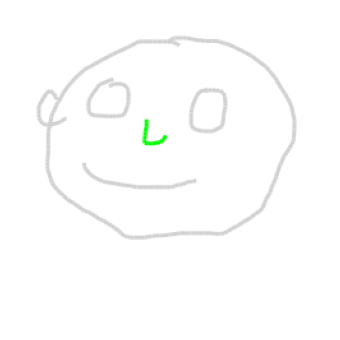

In [51]:
png_indices = [392]
color_selected_part = [1]
obj = CONST.face_json
# obj = CONST.angel_json

row_figsize = 6
column_figsize = 6
num_pngs_per_row = 1
num_rows = 1

fig = plt.figure(figsize=(num_pngs_per_row * row_figsize, num_rows * column_figsize)) 
fig.patch.set_alpha(1)  

for index, idx in enumerate(png_indices):
    plt.subplot(num_rows, num_pngs_per_row, index+1)

    drawing_raw = obj['train_data'][idx]
    image_data = rd.transform_spg_2_svg_png(
        drawing_raw, 
        draw_color = True, 
        stroke_width = 3,
        color_selected = color_selected_part,
    )

    plt.imshow(image_data)
    plt.axis('off')

plt.show()
plt.close()

In [38]:
dfp = get_df()
template_1,template_2 = template[0]
dfp['caption_1'] = dfp.apply(template_1, axis=1)
dfp['caption_2'] = dfp.apply(template_2, axis=1)

In [35]:
root_folder = '/raid/xiaoyuz1/clip_model_checkpoint'
acc_path_name = os.path.join(root_folder, "pleasant-tree-10.pickle")
final_accs, preds, gts = None,None,None
with open(acc_path_name, 'rb') as f:
    _, final_accs, preds, gts = pickle.load(f)
print(final_accs)

{'test': {'face': 0.7430830039525692, 'angel': 0.7035830618892508}, 'dev': {'face': 0.7171314741035857, 'angel': 0.7100977198697068}, 'train': 0.9284064665127021}


In [41]:
cat = 'angel'
split = 'test'
pred,gt = preds[split][cat], gts[split][cat]
                        
reload(rd)
df_cat = dfp[(dfp['category'] == cat) & (dfp['split'] == split)]
df_cat = df_cat.reset_index(drop=True)

In [42]:
pred.shape, len(df_cat)

((614, 2, 2), 614)

In [23]:
np.sum(np.argmax(pred, axis=1).reshape(-1,) == gt) / len(gt)

0.6620553359683794

In [33]:
def get_wrong(pred, gt):
    wrong = []
    for i in np.where(np.argmax(pred, axis=1).reshape(-1,) != gt)[0]:
        row = i // 2
        col = i % 2
        wrong.append((row,col))
    wrong_rows = list(np.unique([x[0] for x in wrong]))
    return wrong_rows

((506, 2, 2), 506)

In [ ]:
# dfo[dfo.apply(lambda x: 'l' in x['no_punc_1'], axis=1)]

In [36]:
wrong = get_wrong(pred,gt)

In [39]:
all_pair_df = rd.all_pair_combination(df_cat, wrong_rows=wrong)

In [40]:
all_pair_df

,word1,word2,total_occurrence,correct#,correct%,correct_row_idx,incorrect_row_idx
0,small,large,18,16,0.888889,"[75, 195, 228, 229, 236, 286, 303, 319, 322, 3...","[416, 421]"
1,short,long,16,8,0.500000,"[27, 82, 89, 111, 216, 434, 472, 498]","[13, 21, 67, 68, 86, 113, 215, 285]"
2,close,open,14,6,0.428571,"[88, 263, 281, 300, 308, 387]","[20, 274, 282, 326, 328, 345, 390, 504]"
3,wide,small,12,10,0.833333,"[12, 64, 167, 176, 179, 216, 257, 335, 412, 495]","[262, 460]"
4,wide,curve,10,3,0.300000,"[82, 167, 265]","[253, 262, 280, 292, 346, 360, 389]"
...,...,...,...,...,...,...,...
1264,crooked,sideways,1,1,1.000000,[3],[]
1265,crooked,open,1,1,1.000000,[3],[]
1266,an,triangular,1,0,0.000000,[],[2]
1267,within,triangular,1,0,0.000000,[],[2]


In [41]:
dfnii = all_pair_df[(all_pair_df['word1'] == 'small') & (all_pair_df['word2'] == 'large')]
dfnii

,word1,word2,total_occurrence,correct#,correct%,correct_row_idx,incorrect_row_idx
0,small,large,18,16,0.888889,"[75, 195, 228, 229, 236, 286, 303, 319, 322, 3...","[416, 421]"


[[0.2413 0.232 ]
 [0.212  0.2537]]


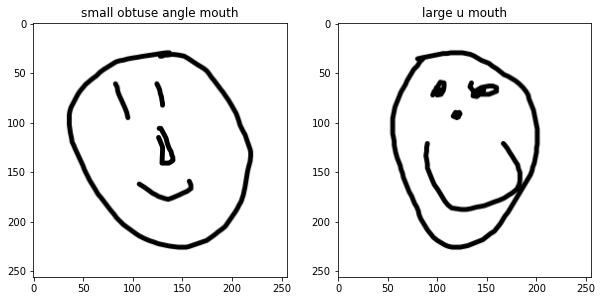

[[0.2328 0.2477]
 [0.2277 0.2484]]


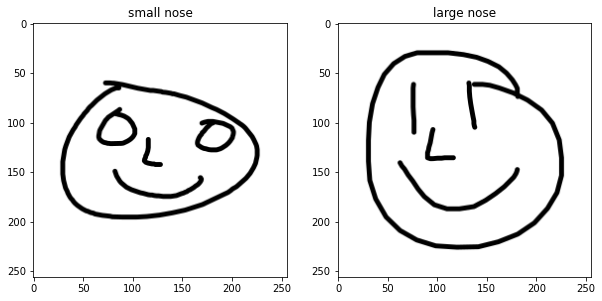

[[0.2267 0.2131]
 [0.2083 0.2266]]


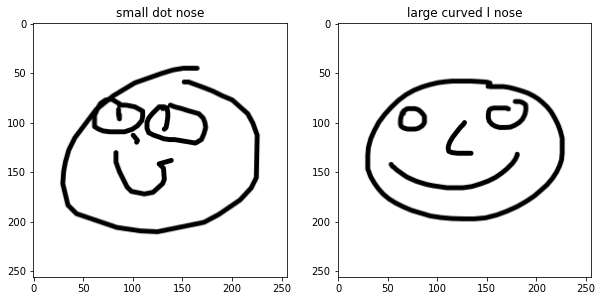

[[0.2732 0.2363]
 [0.2676 0.2474]]


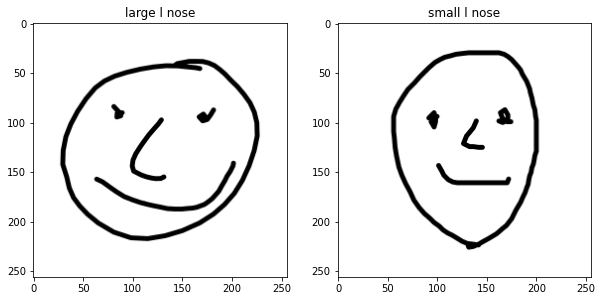

[[0.2422 0.2542]
 [0.1974 0.261 ]]


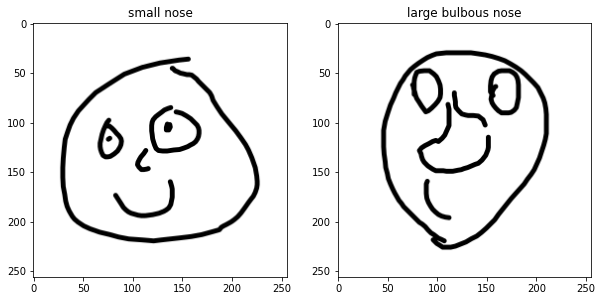

[[0.2212 0.2104]
 [0.2168 0.2708]]


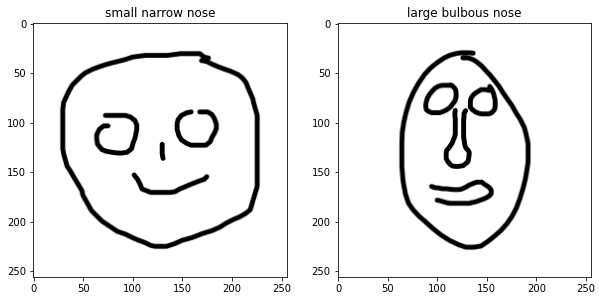

[[0.2217 0.1617]
 [0.1354 0.213 ]]


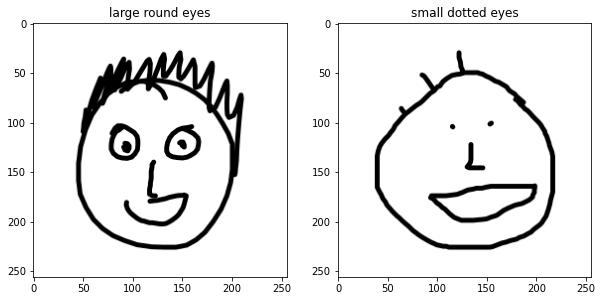

[[0.2288 0.1995]
 [0.148  0.2537]]


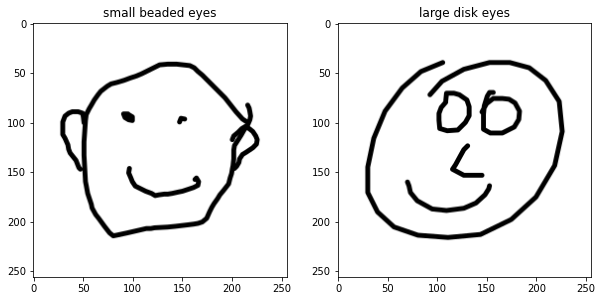

[[0.2251 0.2178]
 [0.1411 0.2292]]


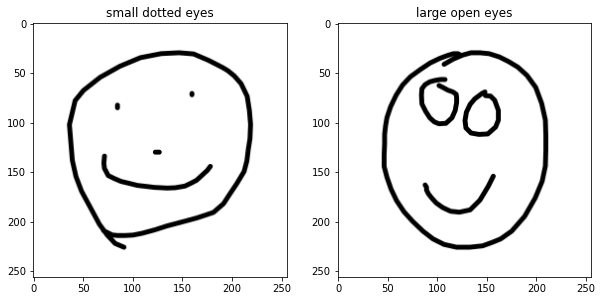

[[0.2366 0.1978]
 [0.1904 0.2394]]


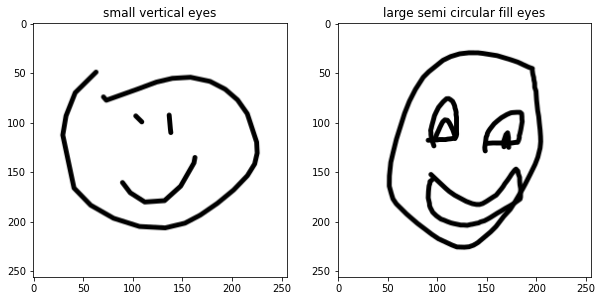

[[0.2461 0.228 ]
 [0.2263 0.2345]]


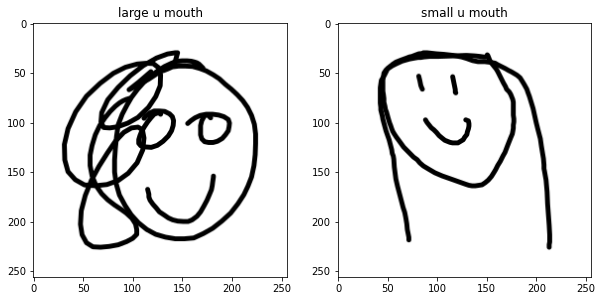

[[0.2646 0.2031]
 [0.217  0.232 ]]


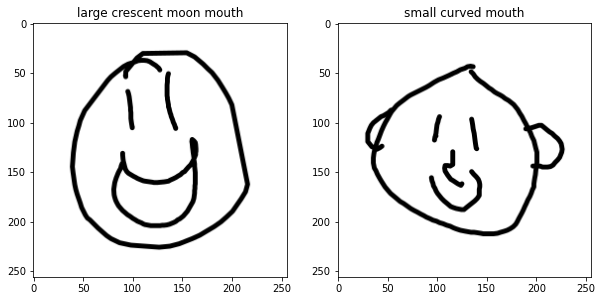

[[0.2507 0.1626]
 [0.2115 0.1984]]


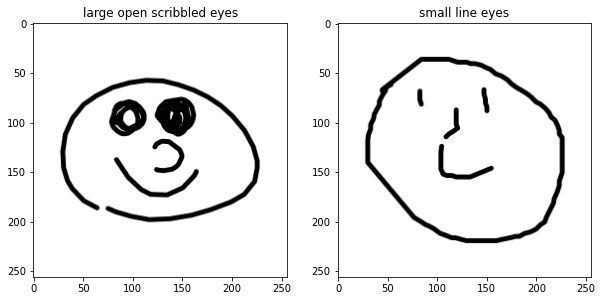

[[0.248  0.1716]
 [0.2035 0.2336]]


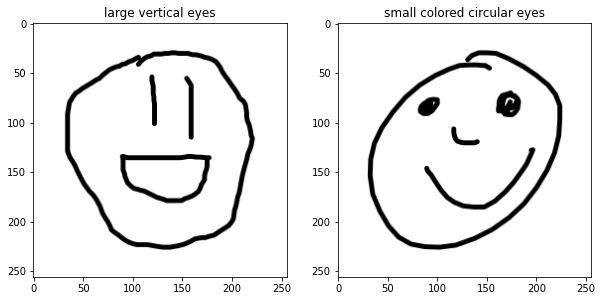

[[0.2438 0.2212]
 [0.2267 0.2306]]


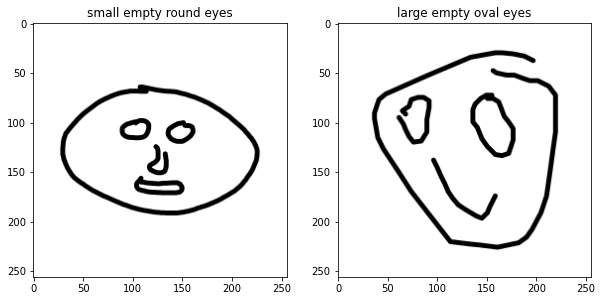

[[0.231  0.2241]
 [0.2247 0.2338]]


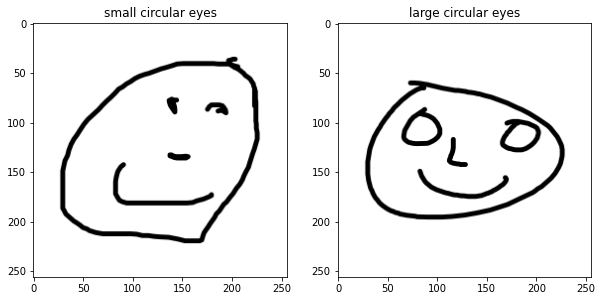

In [43]:
for l in dfnii['correct_row_idx']:
    for row_idx in l:
        row = df_cat.iloc[row_idx]
        print(pred[row_idx])
        p1,p2 = row['image_1'], row['image_2']
        part_idx = row['part']

        w1 = row['no_punc_str_1']
        w2 = row['no_punc_str_2']
        # print(w1,", ", w2)
        ws = [w1,w2]
        plt.figure(figsize=(10,5))
        for i,p in enumerate([p1,p2]):
            img = PIL.Image.open('/raid/xiaoyuz1/sketch_datasets/{}_images_weight_5_all/{}.png'.format(cat,p))
            plt.subplot(1,2,i+1)
            img = img.convert(mode='RGB')
            plt.imshow(img)
            plt.title("{} {}".format(ws[i], CONST.face_parts_idx_dict[part_idx]))
        plt.show()

In [ ]:
for l in dfnii['correct_row_idx']:
    for row_idx in l:
        row = df_cat.iloc[row_idx]
        print(pred[row_idx])
        p1,p2 = row['image_1'], row['image_2']
        part_idx = row['part']

        w1 = row['no_punc_str_1']
        w2 = row['no_punc_str_2']
        # print(w1,", ", w2)
        ws = [w1,w2]
        plt.figure(figsize=(10,5))
        for i,p in enumerate([p1,p2]):
            img = PIL.Image.open('/raid/xiaoyuz1/sketch_datasets/{}_images_weight_5_all/{}.png'.format(cat,p))
            plt.subplot(1,2,i+1)
            img = img.convert(mode='RGB')
            plt.imshow(img)
            plt.title("{} {}".format(ws[i], CONST.face_parts_idx_dict[part_idx]))
        plt.show()